<h1>1. Installation des bibliothèques nécessaires</h1>
<p>Installer toutes les bibliothèques et outils nécessaires pour la manipulation de modèles NLP (comme transformers, datasets), l'optimisation des performances (comme accelerate et bitsandbytes), et le suivi des expériences (avec wandb).</p>

In [2]:
%%capture
%pip install -U transformers  # Pour charger et fine-tuner des modèles NLP
%pip install -U datasets      # Pour manipuler des jeux de données NLP
%pip install -U accelerate    # Pour optimiser l'entraînement multi-GPU ou TPU
%pip install -U peft          # Pour le fine-tuning efficace (LoRA, etc.)
%pip install -U trl           # Pour combiner NLP et apprentissage par renforcement
%pip install -U bitsandbytes  # Pour réduire la mémoire des modèles (8 bits)
%pip install -U wandb         # Pour suivre et visualiser les expériences d'entraînement

In [3]:
%pip install -U peft==0.11.1
%pip install -U "trl<0.9.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.8 MB/s eta 0:00:0000:01
  Attempting uninstall: peft
    Found existing installation: peft 0.14.0
    Uninstalling peft-0.14.0:
      Successfully uninstalled peft-0.14.0
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: trl
    Found existing installation: trl 0.13.0
    Uninstalling trl-0.13.0:
      Successfully uninstalled trl-0.13.0
Note: you may need to restart the kernel to use updated packages.


<h1>2. Importation des Bibliotheques</h1>
<p>Importer les bibliothèques et modules nécessaires pour la gestion des modèles, la configuration de l'entraînement (comme TrainingArguments), ainsi que pour le fine-tuning efficace avec LoRA et autres techniques d'optimisation (comme peft et bitsandbytes).</p>

In [4]:
# Importation des bibliothèques nécessaires
from transformers import (
    AutoModelForCausalLM,  # Charger un modèle de génération de texte (ex. : GPT-like)
    AutoTokenizer,        # Gérer la tokenisation pour le modèle chargé
    BitsAndBytesConfig,   # Configurer la quantification en bits pour optimiser l'utilisation de la mémoire
    HfArgumentParser,     # Parseur pour gérer les arguments de configuration
    TrainingArguments,    # Configurer les hyperparamètres pour l'entraînement
    pipeline,             # Créer des pipelines NLP haut niveau (ex. : chat, résumé)
    logging               # Gestion des logs pour surveiller l'exécution
)
from peft import (
    LoraConfig,               # Configurer les adaptations LoRA pour le fine-tuning
    PeftModel,                # Charger un modèle avec les configurations LoRA
    prepare_model_for_kbit_training,  # Préparer un modèle pour un entraînement quantifié (4-bit/8-bit)
    get_peft_model            # Ajouter un module PEFT à un modèle de base
)
import os                    # Interagir avec le système d'exploitation pour gérer les fichiers et les chemins
import torch                 # Bibliothèque principale pour les calculs de tenseurs et le deep learning
import wandb                 # Bibliothèque pour suivre les métriques et visualiser les expériences
from datasets import load_dataset  # Charger des jeux de données préexistants ou personnalisés
from trl import SFTTrainer, setup_chat_format  # Utilitaires pour le fine-tuning supervisé et le format de chat

<h1>3. Authentification et configuration des tokens</h1>
<p>Authentifier l'utilisateur auprès des services Hugging Face et Kaggle en récupérant les tokens API nécessaires pour accéder aux modèles préexistants et aux secrets.</p>

In [5]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")

login(token = hf_token)

<h1>4. Initialisation de WandB</h1>
<p>Initialiser le suivi des expériences avec wandb, permettant de suivre l'entraînement du modèle, les hyperparamètres, et les résultats en temps réel.</p>

In [6]:
wb_token = user_secrets.get_secret("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune Llama 3 8B on Medical Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: Currently logged in as: oussamanaya8 (oussamanaya8-hassan-ii-university-of-casablanca). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<h1>5. Définition des modèles et des configurations</h1>
<p>Définir les configurations du modèle de base, de LoRA (Low-Rank Adaptation) et de QLoRA, ainsi que la préparation du modèle pour l'entraînement en ajustant la configuration de quantification et d'attention selon le matériel disponible.</p>

In [7]:
base_model = "/kaggle/input/llama-3/transformers/8b-chat-hf/1"
dataset_name = "ruslanmv/ai-medical-chatbot"
new_model = "llama-3-8b-chat-doctor"

<li><b>Configuration torch pour le type de données et l'attention</b></li>

In [8]:
# Set torch dtype and attention implementation
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install -qqq flash-attn
    torch_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
else:
    torch_dtype = torch.float16
    attn_implementation = "eager"

<li>Configuration QLoRA</li>

In [9]:
'''
QLoRA est une extension de LoRA qui utilise la quantification pour encore 
réduire les besoins en mémoire et accélérer les calculs.
'''

# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=attn_implementation
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<li>Configuration LoRA</li>

In [11]:
'''
LoRA est une méthode efficace pour adapter de grands modèles de langage (comme GPT, BERT) 
à des tâches spécifiques sans avoir besoin de réentraînement complet.
'''

# LoRA config
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
model = get_peft_model(model, peft_config)

<h1>6. Importation et préparation du dataset</h1>
<p>Charger et préparer le jeu de données pour l'entraînement, en le formatant selon un modèle de conversation spécifique et en le divisant en ensembles d'entraînement et de test.</p>

In [12]:
#Importing the dataset
dataset = load_dataset(dataset_name, split="all")
dataset = dataset.shuffle(seed=65).select(range(1000)) # Only use 1000 samples for quick demo

def format_chat_template(row):
    row_json = [{"role": "user", "content": row["Patient"]},
               {"role": "assistant", "content": row["Doctor"]}]
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

dataset = dataset.map(
    format_chat_template,
    num_proc=4,
)

README.md:   0%|          | 0.00/863 [00:00<?, ?B/s]

dialogues.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/256916 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
dataset

Dataset({
    features: ['Description', 'Patient', 'Doctor', 'text'],
    num_rows: 1000
})

In [14]:
dataset['text'][3]

'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nFell on sidewalk face first about 8 hrs ago. Swollen, cut lip bruised and cut knee, and hurt pride initially. Now have muscle and shoulder pain, stiff jaw(think this is from the really swollen lip),pain in wrist, and headache. I assume this is all normal but are there specific things I should look for or will I just be in pain for a while given the hard fall?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nHello and welcome to HCM,The injuries caused on various body parts have to be managed.The cut and swollen lip has to be managed by sterile dressing.The body pains, pain on injured site and jaw pain should be managed by pain killer and muscle relaxant.I suggest you to consult your primary healthcare provider for clinical assessment.In case there is evidence of infection in any of the injured sites, a course of antibiotics may have to be started to control the infection.Thanks and take careDr Shailja P Wahal<|eot_i

In [15]:
dataset = dataset.train_test_split(test_size=0.1)

<h1>7. Complaining and training the model</h1>
<p>Définir les hyperparamètres d'entraînement (avec TrainingArguments), configurer le fine-tuning supervisé avec SFTTrainer, et préparer le modèle pour l'entraînement en utilisant le dataset et les configurations de fine-tuning.</p>

In [16]:
# Définition des hyperparamètres pour l'entraînement avec TrainingArguments
training_arguments = TrainingArguments(
    output_dir=new_model,  # Dossier où sauvegarder le modèle après chaque étape d'entraînement
    per_device_train_batch_size=1,  # Taille des mini-lots d'entraînement pour chaque GPU/CPU
    per_device_eval_batch_size=1,   # Taille des mini-lots pour l'évaluation
    gradient_accumulation_steps=2,  # Accumulation des gradients sur 2 étapes avant une mise à jour du modèle
    optim="paged_adamw_32bit",      # Optimiseur AdamW avec une optimisation mémoire (utilise des poids en 32 bits)
    num_train_epochs=1,             # Nombre d'époques (passes complètes sur le jeu de données d'entraînement)
    evaluation_strategy="steps",    # Stratégie d'évaluation : effectuer une évaluation périodique en fonction des steps
    eval_steps=0.2,                 # Intervalle entre chaque évaluation (peut être un pourcentage des étapes totales)
    logging_steps=1,                # Fréquence (en steps) pour consigner les logs pendant l'entraînement
    warmup_steps=10,                # Nombre d'étapes de "warmup" où le taux d'apprentissage augmente progressivement
    logging_strategy="steps",       # Stratégie de journalisation : consigner les logs après un certain nombre de steps
    learning_rate=2e-4,             # Taux d'apprentissage initial pour l'optimiseur
    fp16=False,                     # Désactiver l'entraînement en 16 bits flottants (float16)
    bf16=False,                     # Désactiver l'entraînement en 16 bits bfloat (meilleur pour certains GPU comme A100)
    group_by_length=True,           # Grouper les séquences de longueurs similaires pour améliorer l'efficacité
    report_to="wandb"               # Outil pour le suivi des métriques d'entraînement (ici Weights & Biases)
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Configuration des paramètres pour le fine-tuning supervisé avec SFTTrainer
trainer = SFTTrainer(
    model=model,                  # Modèle de base utilisé pour l'entraînement (déjà configuré avec LoRA ou autre adaptation)
    train_dataset=dataset["train"],  # Jeu de données utilisé pour l'entraînement (partie "train" du dataset)
    eval_dataset=dataset["test"],    # Jeu de données utilisé pour l'évaluation (partie "test" du dataset)
    peft_config=peft_config,         # Configuration PEFT (ex. : paramètres LoRA) pour optimiser le fine-tuning
    max_seq_length=512,              # Longueur maximale des séquences de texte à traiter par le modèle
    dataset_text_field="text",       # Champ du dataset contenant le texte à utiliser pour l'entraînement
    tokenizer=tokenizer,             # Tokenizer associé au modèle pour transformer le texte en tokens
    args=training_arguments,         # Hyperparamètres d'entraînement définis précédemment avec `TrainingArguments`
    packing=False                    # Désactive le "packing", c.-à-d. la concaténation de plusieurs séquences pour optimiser les lots
)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


<h1>8. Entraînement du modèle</h1>
<p>Lancer l'entraînement du modèle et suivre les courbes de perte pour évaluer la performance pendant l'entraînement, avec visualisation des résultats à l'aide de matplotlib.</p>

In [18]:
tokenizer.pad_token = tokenizer.eos_token

In [19]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
90,2.514300,2.492289
180,2.280600,2.438050
270,3.096300,2.420310
360,2.756600,2.382357
450,2.562500,2.372416


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=450, training_loss=2.472824313905504, metrics={'train_runtime': 1181.0067, 'train_samples_per_second': 0.762, 'train_steps_per_second': 0.381, 'total_flos': 9468028544237568.0, 'train_loss': 2.472824313905504, 'epoch': 1.0})

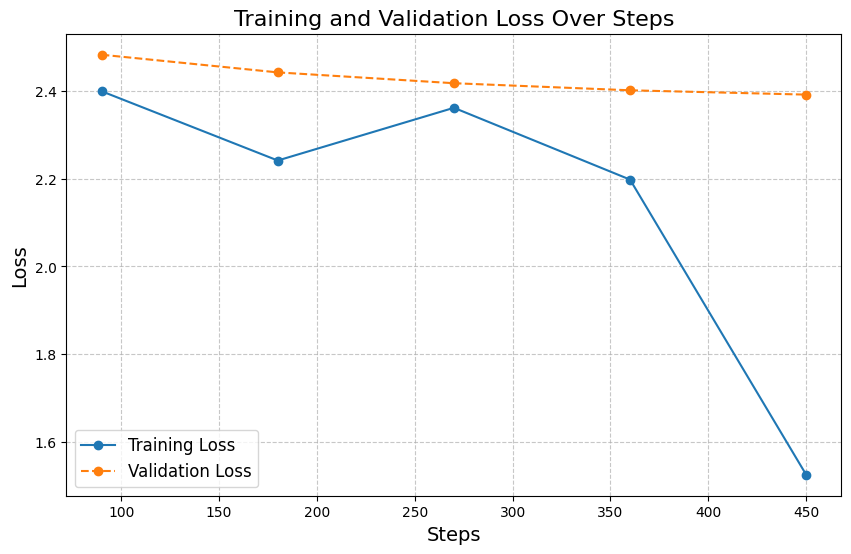

In [22]:
import matplotlib.pyplot as plt

# Données des étapes et des pertes
steps = [90, 180, 270, 360, 450]
training_loss = [2.400100, 2.241900, 2.362300, 2.198300, 1.524300]
validation_loss = [2.483516, 2.443169, 2.418442, 2.402273, 2.392415]

# Tracé des courbes
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label="Training Loss", marker='o', linestyle='-')
plt.plot(steps, validation_loss, label="Validation Loss", marker='o', linestyle='--')

# Ajout de titres et de légendes
plt.title("Training and Validation Loss Over Steps", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Affichage du graphe
plt.show()

<h1>9. Model evaluation</h1>
<p>Terminer le suivi avec wandb et configurer le modèle pour l'évaluation, en permettant d'utiliser le cache du modèle lors des inférences.</p>

In [23]:
wandb.finish()
model.config.use_cache = True

eval/loss,█▅▄▂▁
eval/runtime,▁▅▃█▁
eval/samples_per_second,█▄▆▁█
eval/steps_per_second,█▄▆▁█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▅▅▄▅▃▃▄▆█▃▆▄▆█▄▅▅▄▃▄▄▄▅▂▅▄▅▃▄▅▇▄▁▁▄▄▄▄▄
train/learning_rate,▄██████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▁▁▁▁▁
train/loss,█▆▆▅▄█▆▅▅▄▅▇▅▅▅▅▁▆▆▄▂▄▄▂▅▅▇▅▃▄▂▄▄▂▅▄▅▄▄▄
eval/loss,2.37242
eval/runtime,48.8854


<h1>10. Test</h1>
<p>Tester le modèle en générant des réponses à des entrées simulées (questions d'un utilisateur), en appliquant la tokenisation et en décodant la réponse générée par le modèle.</p>

In [24]:
messages = [
    {
        "role": "user",
        "content": "Hello doctor, I have bad acne. How do I get rid of it?"
    }
]

"""messages = [
    {
        "role": "user",
        "content": "Hello doctor, I've been feeling very tired lately and have frequent headaches. What could be causing this?"

    }
]"""

'messages = [\n    {\n        "role": "user",\n        "content": "Hello doctor, I\'ve been feeling very tired lately and have frequent headaches. What could be causing this?"\n\n    }\n]'

In [25]:
prompt = tokenizer.apply_chat_template(messages, tokenize=False, 
                                       add_generation_prompt=True)

inputs = tokenizer(prompt, return_tensors='pt', padding=True, 
                   truncation=True).to("cuda")

outputs = model.generate(**inputs, max_length=150, 
                         num_return_sequences=1)

text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(text.split("assistant")[1])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




Hi. I can understand your concern. Acne is a common problem in teenagers. It is caused by hormonal changes. It can be treated with antibiotics, retinoids, and hormonal pills. I would suggest you to consult a dermatologist and get evaluated. You can use a topical antibiotic like erythromycin or clindamycin. You can also use a retinoid like retinol or adapalene. You can also use a hormonal pill like birth control pills. You can also use a spot treatment like benzoyl peroxide or salicylic acid. You can also use a face wash


<h1>11. Saving the model file</h1>
<p>Sauvegarder le modèle fine-tuné sur le système local et le pousser vers Hugging Face pour une utilisation ultérieure.</p>

In [ ]:
trainer.model.save_pretrained(new_model)
trainer.model.push_to_hub(new_model, use_temp_dir=False)

Link to the model : <a href="https://huggingface.co/OussamaNaya/llama-3-8b-chat-doctor">
llama-3-8b-chat-doctor</a>